# CAB420, Clustering, Example 8: Applying Clustering to Diarisation
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

In this example we'll look at an example application of clustering: diarisation. Diarisation is the task of grouping instances by their identity, and is usually applied to either faces/people or segments of speech. In a video/image context, the task is determining which instances of a face belong to the same person, for speech it's determining who spoke when.

We'll focus on grouping face images in this example as:
* it's easier to display the images than listen to audio
* there is a very easy to use python face detection and recognition library that we can use to enable this, meaning we can get straight to our application much quicker

We're going to use this [face-recognition package](https://pypi.org/project/face-recognition/) which makes use of the excellent [DLib](http://dlib.net/) toolkit.

To achieve our task, we have a few steps to follow. We need to:
* Locate faces
* Encode each of the faces to capture identify information, obtaining a set of embeddings (like we saw out of our Siamese and Triplet networks)
* Cluster the embeddings

We'll rely on the above mentioned face-recognition and DLib packages to help with the first two tasks, and then explore our different clustering methods for the third.

## Too Long; Didn't Read
* For K-Means and a GMM, picking K is non-trivial. Our BIC and Approximate BIC curves aren't of much use due to the high dimensionality of the samples and the small distances between the samples. However, for different data (and in particular for larger amounts of data) these may be of more use.
* The GMM seems to perform slightly better than K-Means, with clusters that appear to be slightly more focussed on a single identify.
* HAC produces the best clustering, but also gives us the best way to select the number of clusters in that we don't need to pick an arbitrary number of clusters straight off. Rather we can select a distance at which we stop clustering. Ideally, this would be informed by some other investigation of the data.
* DBScan produces ok results, but it's hard to tune the hyper-parameters. One nice thing we see with DBScan is the value of the noise cluster, which does manage to capture a number of the erroneous faces.
* Several of the errors that we see in our clustering are a result of either very low resolution faces, or outright errors in the face recognition. This is often referred to as the "front-end effect", i.e. errors in the early stages of our system (in this case the face detection) propagate through the later stages of the system, causing more errors there.

In [2]:
import face_recognition
import cv2
from matplotlib import pyplot as plt
import numpy
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import hdbscan

## Face Detection and Encoding

### Our Data

We're going to use a small video of clips taken from the TV show Blackadder (series 2 in particular). The clip is about 4 minutes long - so for the sake of run-time we don't want to take every frame. We'll take every 50th, but you can control this with the variable below. Feel free to also drop in your own video clip of choice here.

In [3]:
sample_frequency = 50
marked_up_frames = []
cropped_faces = []
embeddings = []

vid = cv2.VideoCapture('../data/BlackadderHD.mp4')

We'll use OpenCV to read the video and extract out frames. For each frame we will check if it's one we want to process, as we only want every 50th frame. If the frame is one that we wish to use we will:
* convert the frame to RGB (from opencv's BGR)
* find the faces, using `face_recognition.face_locations`
* encode the faces, using `face_recognition.face_encodings`
* extract out cropped images of each face for later visualisation
* markup the input image with detected boxes and save that for later visualisation

One key parameter to note in all of this is the `model="cnn"` bit in the call to `face_recognition.face_locations`. This will use the inbuilt CNN to do the detection, which is more accurate, but also much slower. If you are impatient, or have a slow computer, remove this and it will use a simpler HOG (histogram of orientated gradients) approach. **If you don't have a GPU, I really don't recommend using the CNN option.**

In [4]:
count  = 0
while(vid.isOpened()):
    # Capture frame-by-frame
    ret, frame = vid.read()
    if ret == True:
        if (count % sample_frequency) == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            face_locations = face_recognition.face_locations(frame)#, model="cnn")
            face_encodings = face_recognition.face_encodings(frame, face_locations)
            
            for face in face_locations:
                cropped_faces.append(frame[face[0]:face[2], face[3]:face[1]].copy())
                
            for face in face_locations:
                cv2.rectangle(frame, (face[3], face[0]), (face[1], face[2]), (0, 0, 255), 4)
                
            embeddings = embeddings + face_encodings

            marked_up_frames.append(frame)
        count += 1
    else: 
        break

vid.release()

The end result of all this is a collections of faces, each of which we have an embedding for. The embedding (hopefully) captures some information about the identity of the person in the image.

### Some Pictures

As always, it's a good idea to visualise some things. Let's start with some input frame with detected faces marked with rectangles.

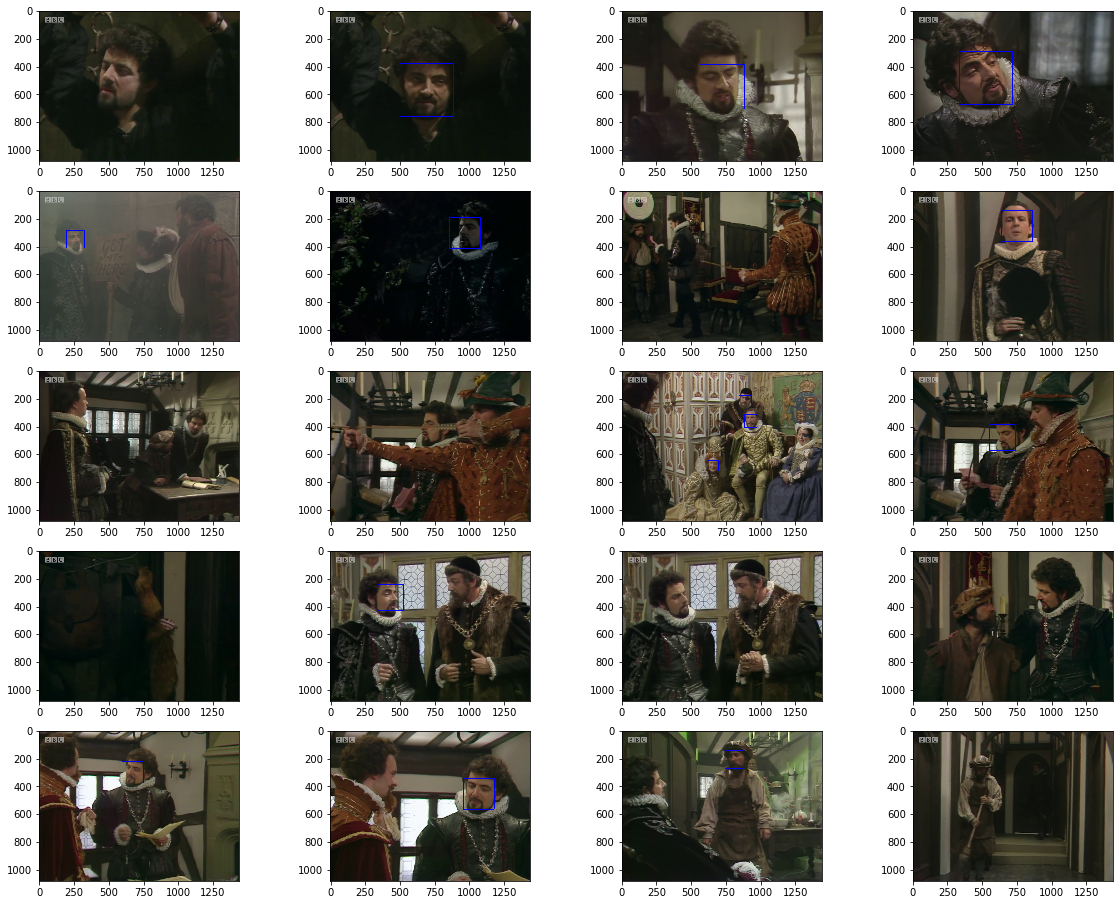

In [5]:
fig = plt.figure(figsize=[20, 16])
for i in range(0, 60, 3):
    ax = fig.add_subplot(5, 4, (i + 3)/3)
    ax.imshow(marked_up_frames[i]);

From the above, we can see that we've captured most faces when they are front-on to the camera, but have not done as well on the other faces that appear at other, more side-on angles.

Looking at the cropped faces up close. We can see that:
* We have lots of variation in pose, expression, etc.
* Resolution is not great (this is from the 80's, HD was not a thing yet), and we have some compression artefacts as well (thanks BBC youtube channel).
* Face detection is not perfect in terms of alignment. We have some faces that are nicely centred, others not so much.
* Most of the faces belong to one character (Blackadder, the main character, so fair enough really), though some others are scattered in there.

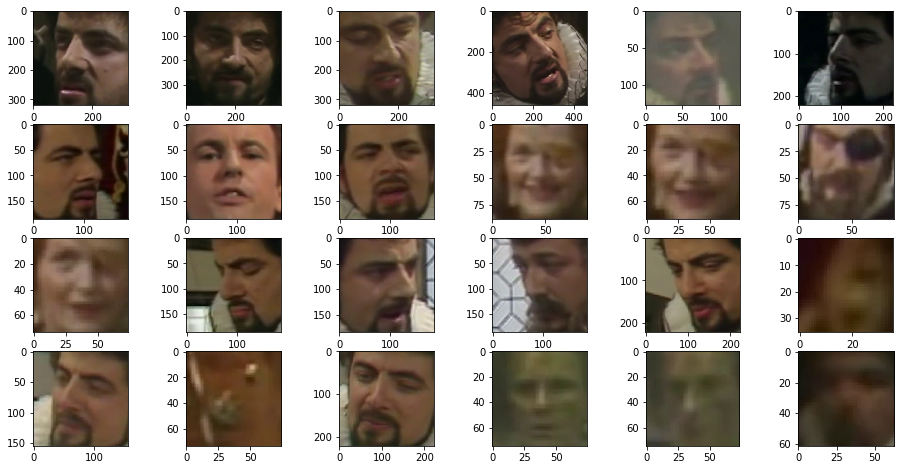

In [6]:
fig = plt.figure(figsize=[16, 8])
for i in range(0, 48, 2):
    ax = fig.add_subplot(4, 6, (i + 2)/2)
    ax.imshow(cropped_faces[i]);

### t-SNE Visualisation

As a quick test before we move onto our main task, we can use t-SNE to visualise our embeddings and see if there is any sort of grouping going on.

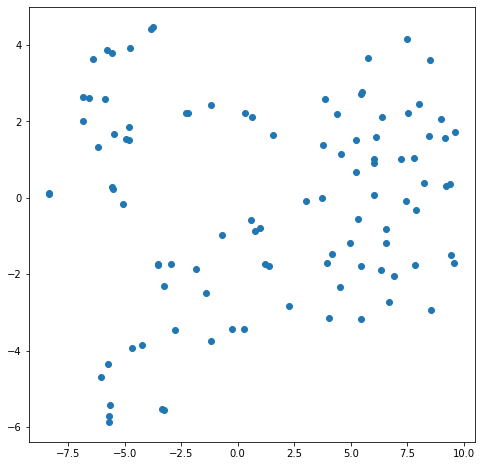

In [7]:
tsne_embeddings = TSNE(random_state=42).fit_transform(embeddings)
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1]);

From the above, we may perhaps say that this doesn't look too promising. We have some tightly grouped pairs, which are probably faces belonging to the same subject in concecutive frames (i.e. similar pose, lighting, costume, etc). Other than that, it looks a little rough.

Keep in mind though that this is also taking a 128 dimension representation and showing it in 2D. So while it is trying to mimic the distribution in the high dimensional space, information is unavoidably being lost.

## Diarisation

On to our main task then. What we'd ideally like to end up with is a set of clusters such that we have one cluster per unique person. That cluster will contain all images of that person, and nothing else. What we expect here from the above visualisations is to have one big cluster (Blackadder) and then a series of smaller clusters.

Let's have a look at our three clustering methods for this task.

## K-Means

First up, we'll try K-Means. The raises the obvious question of what should K be. We'll start by running a bunch of possible options, and plotting our reconstruction error and approximate BIC.

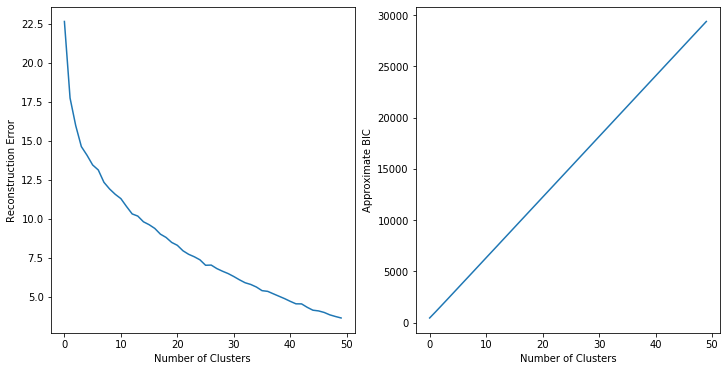

In [8]:
def compute_approximate_bic(kmeans,X):
    
    k = numpy.shape(kmeans.cluster_centers_)[0]*(numpy.shape(kmeans.cluster_centers_)[1] + 1)
    m = len(X)
    
    approx_bic = m*numpy.log(kmeans.inertia_ / m) + k*numpy.log(m)
    return approx_bic    

recon_error = []
bic = []

for i in range (50):
    kmeans = KMeans(n_clusters=(i+1), random_state=4).fit(embeddings)
    recon_error.append(kmeans.inertia_)
    bic.append(compute_approximate_bic(kmeans, numpy.array(embeddings)))

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(recon_error)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Reconstruction Error');    

ax = fig.add_subplot(1, 2, 2)
ax.plot(bic)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Approximate BIC');

Performance wise, this looks a little unexpected. Considering the approximate BIC, we see our best option is 1 cluster. For the reconstruction error, our elbow is probably around 10-15, but it's hard to see a clear point.

Why does our BIC give us so little? The reason is down to our data. Let's get the distance between some of our embeddings

In [9]:
import sklearn
print(sklearn.metrics.pairwise.euclidean_distances(embeddings[0].reshape(1, -1), embeddings[1].reshape(1, -1)))
print(sklearn.metrics.pairwise.euclidean_distances(embeddings[0].reshape(1, -1), embeddings[2].reshape(1, -1)))
print(sklearn.metrics.pairwise.euclidean_distances(embeddings[0].reshape(1, -1), embeddings[3].reshape(1, -1)))
print(sklearn.metrics.pairwise.euclidean_distances(embeddings[0].reshape(1, -1), embeddings[4].reshape(1, -1)))

[[0.24081507]]
[[0.47046455]]
[[0.53934011]]
[[0.5428572]]


We can see that the distance is quite small. What this means is that the reconstruction loss term is swamped by the penalty term. Our penalty term is $k log(m)$, where $k$ is the number of parameters. As we have 128 dimensions, $k$ is at least 129 (128 dimensions plus one cluster), which means that this term dominates. With that in mind, let's go with the rough elbow of the curve and set $k=10$.

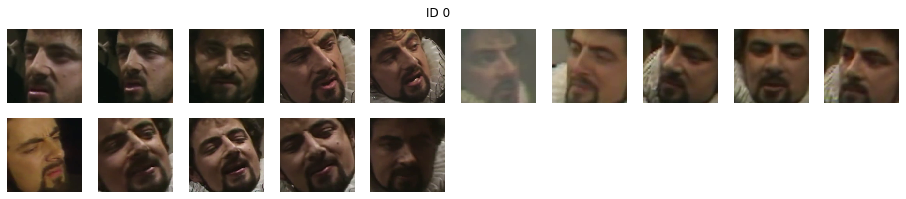

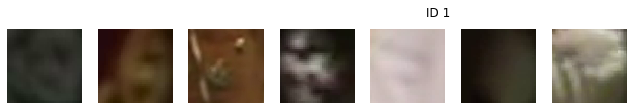

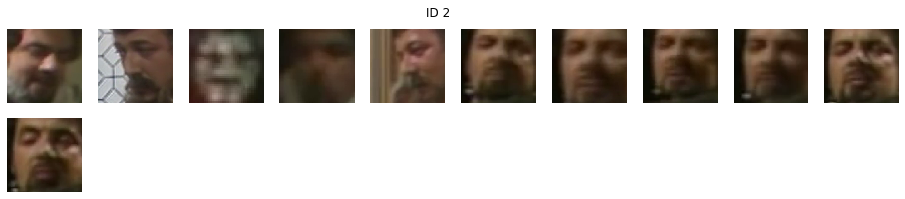

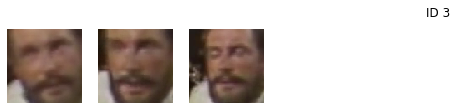

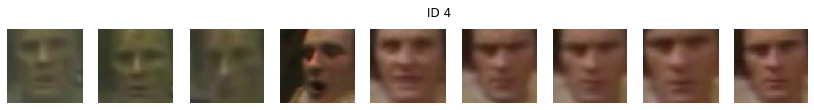

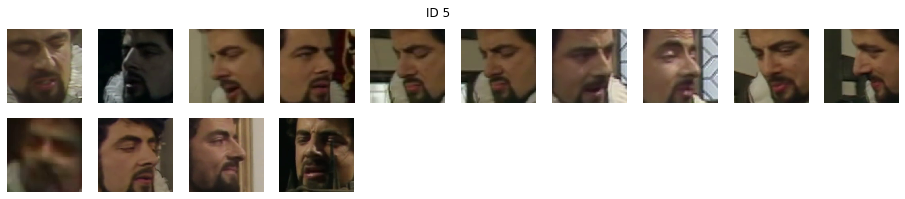

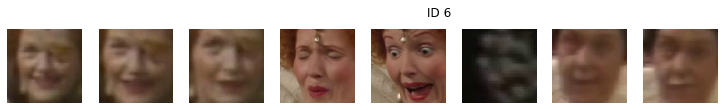

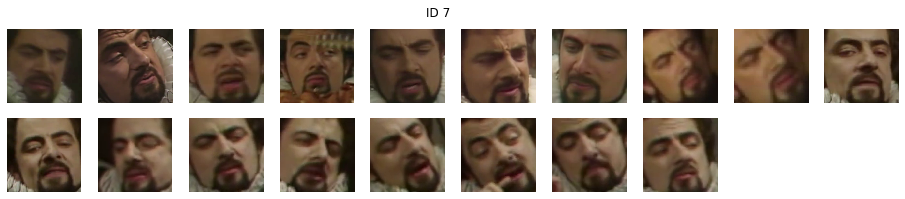

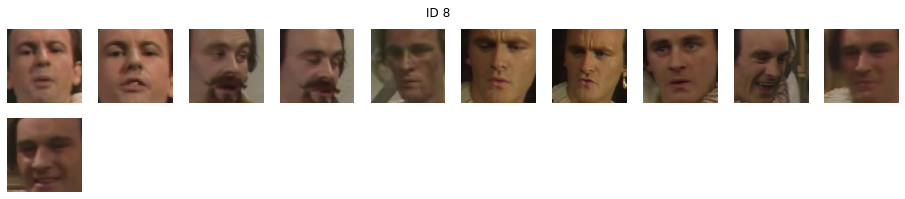

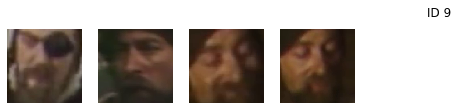

In [10]:
kmeans = KMeans(n_clusters=10, random_state=4).fit(embeddings)

def plot_faces(faces, labels):
    for face in (numpy.unique(labels)):
        fig = plt.figure(figsize=[16, 3])
        fig.suptitle('ID ' + str(face))
        indexes = [i for i,x in enumerate(labels) if x == face]
        for j in range(min(len(indexes), 20)):
            ax = fig.add_subplot(2, 10, j+1)
            ax.set_axis_off()
            ax.imshow(cropped_faces[indexes[j]]);
            
plot_faces(cropped_faces, kmeans.labels_)

K-Means does Ok. We have Blackadder being split across multiple clusters, though each of his clusters contain mostly only Blackadder. Other clusters seem to mostly be one or two people - so not terrible.

## GMM

We'll now consider a GMM. Looking at the BIC, we get a similar result to earlier.

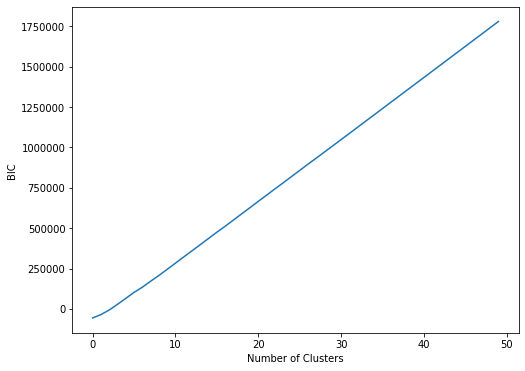

In [11]:
bics = []
for i in range (50):
    gmm = GaussianMixture(i+1, random_state=4)
    gmm.fit(embeddings)
    bics.append(gmm.bic(numpy.array(embeddings)))
    
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(bics)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('BIC');

We see a similar result with our BIC for the GMM to what we had above with K-Means. Again, 1 cluster is probably not optimal for our purposes, so we'll stick with 10.

In [64]:
gmm = GaussianMixture(10, random_state=4)
gmm.fit(embeddings)

GaussianMixture(n_components=10, random_state=4)

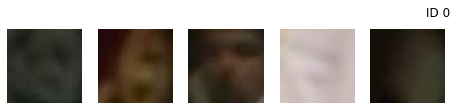

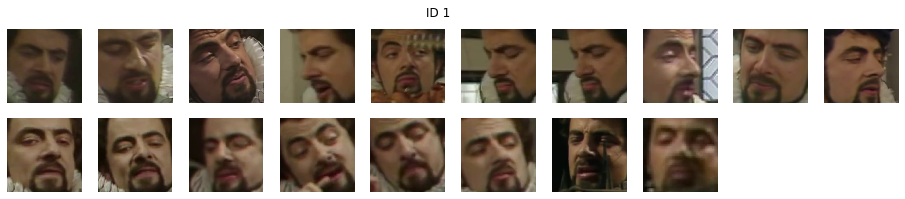

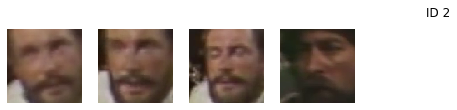

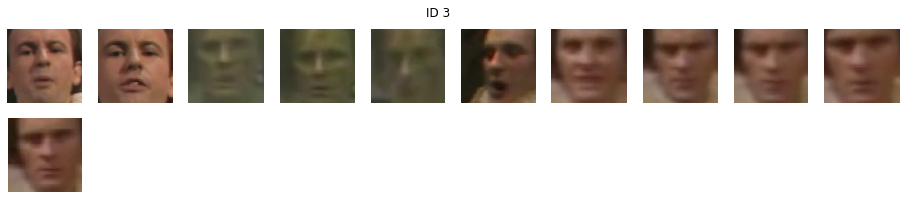

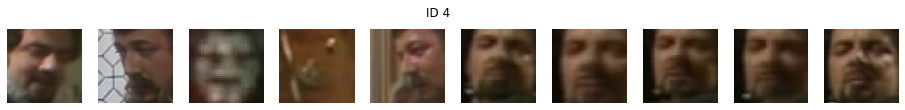

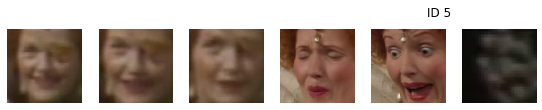

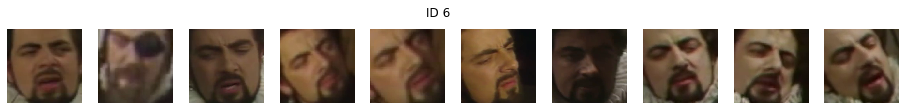

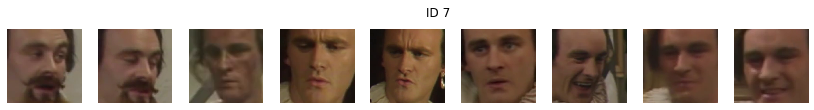

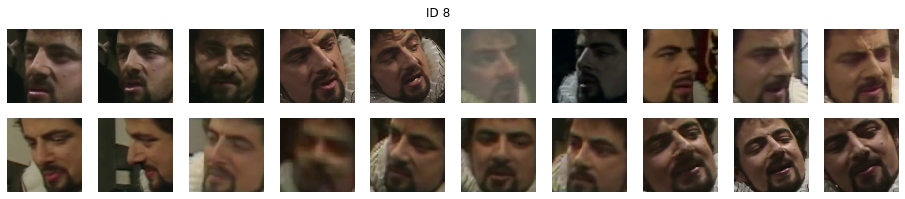

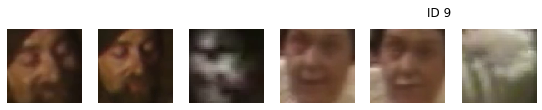

In [65]:
labels = gmm.predict(embeddings)
            
plot_faces(cropped_faces, labels)

Results wise, I'd say we're a little ahead of K-Means. Without ground truth data, it's hard to say for certain, but on the whole clusters seem a bit cleaner. This will in large part be due to the GMM being able to model different densities and shapes within the clusters, allowing the model to better fit the data.

## HAC

Now, let's look at HAC. I'm going to use the complete linkage criteria, and I'm going to stop clustering at a distance of 0.75. This distance of 0.75 is somewhat arbitrary. Ideally, I could look at a bunch of pairs of embeddings (both matching pairs and mismatched pairs) and determine typical distances for matched and mismatched pairs (or estimate the distributions for matched and mismatched distances) to help determine the threshold. To do this however, we'd need ground truth data. As such, we'll run with 0.75.

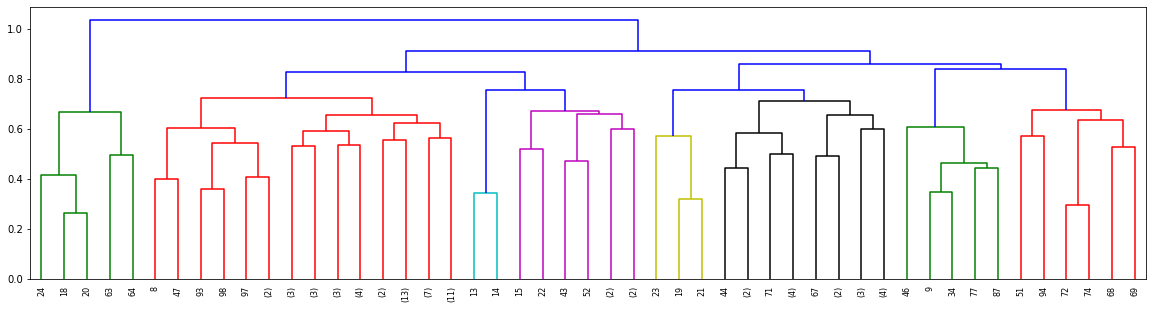

In [50]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
fig = plt.figure(figsize=[20, 5])
hac = AgglomerativeClustering(distance_threshold=0.75, n_clusters=None, linkage='complete', compute_full_tree=True)
hac = hac.fit(embeddings)
ax = fig.add_subplot(1, 1, 1)
plot_dendrogram(hac, truncate_mode='level', p=6)

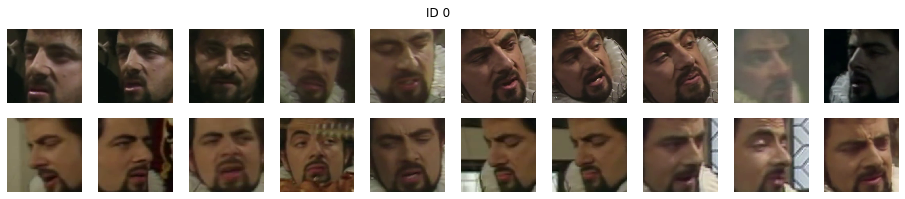

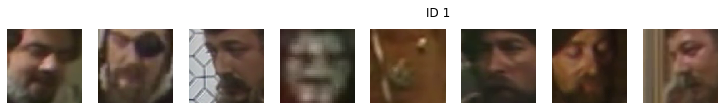

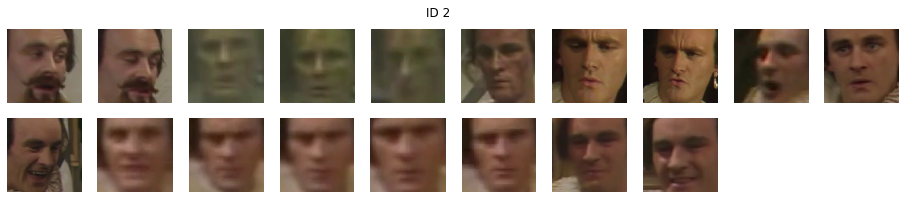

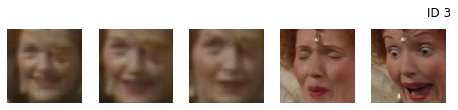

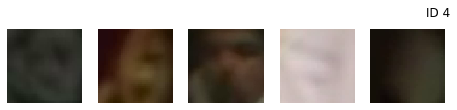

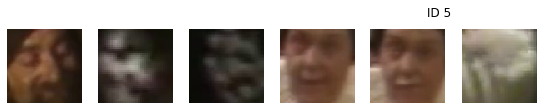

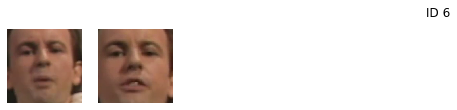

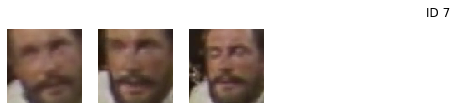

In [51]:
plot_faces(cropped_faces, hac.labels_)

On the whole, this leads to much better results. We get fewer clusters, and most clusters capture just the one subject. Of biggest problems come from faces which are very poor resolution, or not correctly detected.

The advantage of HAC here is that we can set our clustering to only merge up to a point. We're not tied to some fixed number of clusters, rather we can determine that based on the similarity we observe in the data.

## DBScan

Let's now try DBScan. As per HAC, we don't need to specify the number of clusters, but we do need to select values for eps and the minimum number of points in a clusters. We'll use 0.5 and 2.

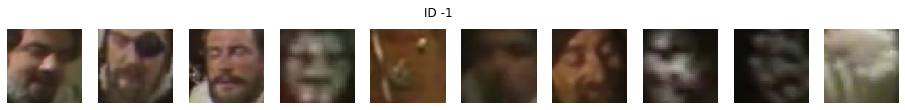

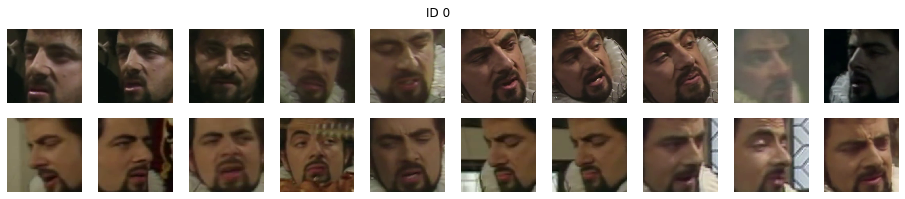

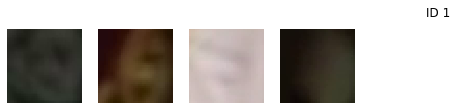

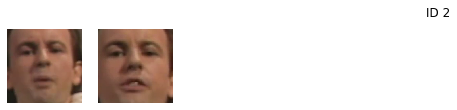

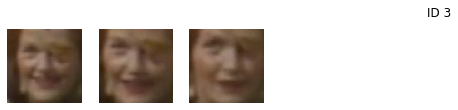

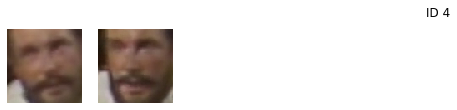

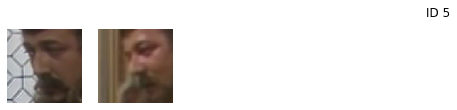

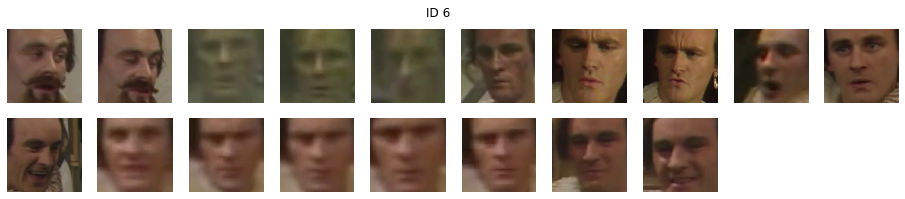

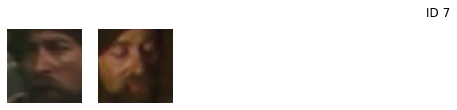

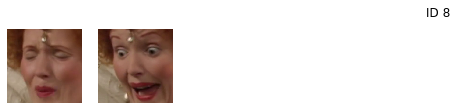

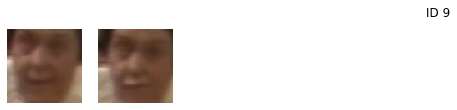

In [56]:
clustering = DBSCAN(eps=0.50, min_samples=2).fit(embeddings)
plot_faces(cropped_faces, clustering.labels_)

This works Ok. One nice aspect of DBScan is the noise cluster (label -1) which actually contains a lot of the very low res or incorrectly detected faces. There are however a couple of valid faces in there that should have been paired up, so this is not perfect. Aside from that we see our clustering generally does pretty well.

Finally, let's quickly try HDBScan. Here we have just the one hyper-parameter (minimum cluster size).

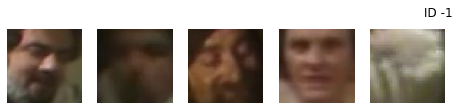

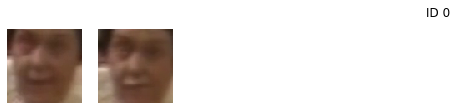

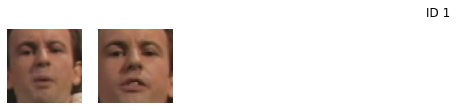

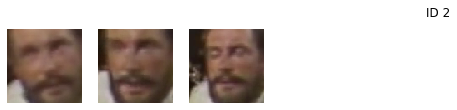

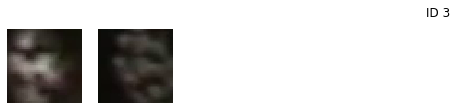

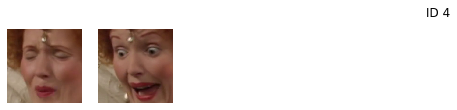

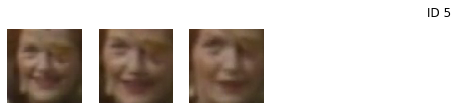

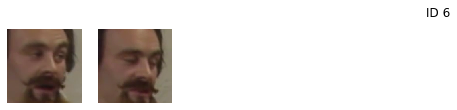

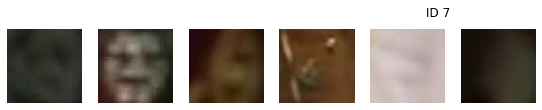

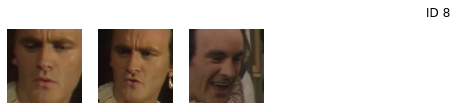

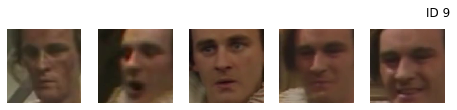

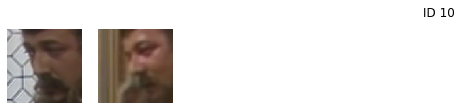

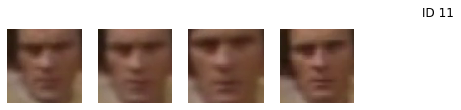

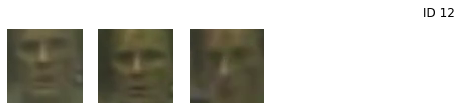

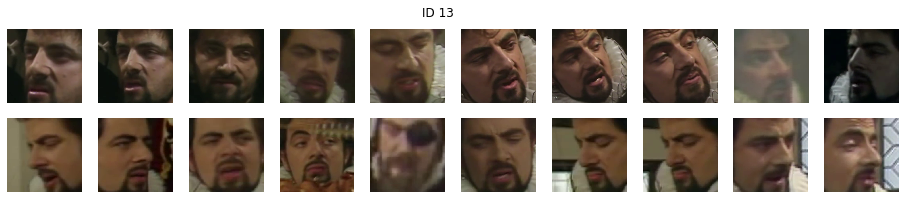

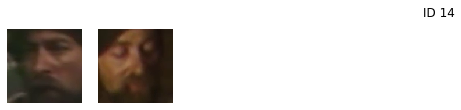

In [57]:
clustering = hdbscan.HDBSCAN(min_cluster_size=2).fit(embeddings)
plot_faces(cropped_faces, clustering.labels_)

Results here are perhaps less good. We see that our noise cluster contains more actual faces that noise samples, and most of the junk is now in cluster 7. In general, we've over-clustered using HDBScan (ended up with more clusters than there actually are) and we can see that we've often split faces based on scenes (consider cluster 4 and 5 - same subject in each, but from different scenes with different properties).

## Final Thoughts

In this example we've had a look at the task of diarisation. This invovles grouping instances from a piece of data such that we have one cluster per identity, and (ideally) each cluster contains all instances of a given identity. In our case, we've looked at face diarisation.

Comparing the three clustering methods, we find that:
* For K-Means and a GMM, picking K is non-trivial. Our BIC and Approximate BIC curves aren't of much use due to the high dimensionality of the samples and the small distances between the samples.
* The GMM seems to perform slightly better than K-Means, with clusters that appear to be slightly more focussed on a single identify.
* HAC produces the best clustering, and also gives us the best way to select the number of clusters in that we don't need to pick the number of clusters. Rather we can select a distance at which we stop clustering. Ideally, this would be informed by some other investigation of the data. 
  * It's worth noting that for a very large dataset, HAC would come with it's own limitations. HAC relies on going a complete pair-wise comparison of the entire set of data. Here we only have a couple of hundred faces, so we have to do ~$200^2$ comparisons. If however we have $10,000$ faces, we then need to complete (and store the results of) $10,000^2 = 100,000,000$ comparisons.
* DBScan is also quite good (more so than HDBScan), and the noise cluster does help filter some of the junk faces that we have extracted. It is very sensitive to the value set for eps however.
  * This example doesn't show the failed attempts at finding good settings for DBScan. If the DBScan parameters are not set well, it really does not go well.
* Several of the errors that we see in our clustering are a result of either very low resolution faces, or outright errors in the face recognition. This is often referred to as the "front-end effect", i.e. errors in the early stages of our system (in this case the face detection) propagate through the later stages of the system, causing more errors there. This is a common problem in many real-world machine learning problems, where there are multiple stages that build on one another.

With respect to HAC, as noted above while it works best here, for large volumes of data it becomes challenging and the need to compute the distance between all pairs of samples does not scale well as dataset size increases. GMMs and K-Means actually scale far better.

The other catch with HAC is that we can't add points to our clusters after the fact - however in this application where have all the data up front, that is not an issue. This is also a limitation for DBScan.

### Other things you can do

There is lots to explore with this example. Consider:
* Grab your own video and diarise it.
* Decrease the number of clusters for K-Means and the GMM to induce underclustering; and then increase it to create overclustering and look at how the two methods respond.
* Explore different thresholds for HAC. Pick a small number of sample faces and see if you can determine a better threshold by looking at typical distances between faces.
* Try different linkage criteria with HAC, and explore how that changes performance.

### Things we ignored and could do better

We've taken a very simplistic view of diarisation here, and actually ignored a lot of other information that could help us. For example, we could:
* Track faces through the video sequence, allowing us to quickly group instances of the same face in a scene.
* Detect scene changes (or changes in camera) to allow us to help determine when a new face (or faces) is visible.

Both of these items would allow us to quickly group all instances of a face where we can be very sure it's the same person. Both could however also introduce other errors (what if we missed a scene change?). This also creates one new challenge, in that now rather than comparing individual faces, we'd have to compare sets of faces, which is slightly harder than what we have here.

## But what if I want to do this with audio?

The process is much the same. You need to:
* Locate segments of speech in the audio, this is called speech activity detection is the task of separating speech from non-speech.
* Encode each of those segments to capture identity information. A siamese network trained for speaker recognition would achieve this. One thing to note with audio is that often we'll split the audio into fixed length segments (say 1 second) and treat each of those as a sample.
* Cluster those encodings.

The clustering stage will work exactly as we've looked at here, we're now just clustering speech data rather than images.